In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib

In [32]:
# Step 2: Load and SAFELY Clean the Dataset

df = pd.read_csv('BetelPrice.csv')

# Convert Date
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Sort by Date
df = df.sort_values('Date').reset_index(drop=True)

# --- SAFE CLEANING: Only drop known garbage columns ---
print("Original columns:", df.columns.tolist())

# Explicitly drop only the unwanted columns by name
garbage_columns = ['Unnamed: 6', ' ']  # From your output
df = df.drop(columns=[col for col in garbage_columns if col in df.columns])

print("Columns after safe cleaning:", df.columns.tolist())

# Now verify expected columns are present
expected_cols = ['Date', 'District', 'Market Type', 'Commercial Type', 'Quality Grade', 'Price']
missing = [col for col in expected_cols if col not in df.columns]
if missing:
    print("WARNING: Missing expected columns:", missing)
else:
    print("All expected columns present!")

# Basic price cleaning
df = df.dropna(subset=['Price'])
df = df[df['Price'] > 0].reset_index(drop=True)

print("Final rows:", len(df))
print("Price range:", df['Price'].min(), "to", df['Price'].max())

Original columns: ['Date', 'District', 'Market Type', 'Commercial Type', 'Quality Grade', 'Price', 'Unnamed: 6', ' ']
Columns after safe cleaning: ['Date', 'District', 'Market Type', 'Commercial Type', 'Quality Grade', 'Price']
All expected columns present!
Final rows: 9429
Price range: 20 to 30000


In [33]:
categorical_cols = ['District', 'Market Type', 'Commercial Type', 'Quality Grade']

# Quick check of unique values
for col in categorical_cols:
    print(f"{col}: {df[col].unique().tolist()}")

# One-hot encode
# Use drop_first=True (recommended - avoids redundant columns)
df_encoded = pd.get_dummies(df, columns=categorical_cols, dtype=float, drop_first=True)

# Or if you prefer all columns: drop_first=False

encoded_cols = [col for col in df_encoded.columns if col not in ['Date', 'Price']]
print("\nEncoded columns count:", len(encoded_cols))
print("Encoded columns:", encoded_cols)
print("Total features (Price + encoded):", len(['Price'] + encoded_cols))

# Prepare data array
features = ['Price'] + encoded_cols
data = df_encoded[features].values.astype(np.float32)
dates = df_encoded['Date'].values

District: ['Kurunegala', 'Gampaha']
Market Type: ['Export', 'Local']
Commercial Type: ['Peedunu', 'Keti', 'Kanda', 'Korikan']
Quality Grade: ['Premium', 'Standard']

Encoded columns count: 6
Encoded columns: ['District_Kurunegala', 'Market Type_Local', 'Commercial Type_Keti', 'Commercial Type_Korikan', 'Commercial Type_Peedunu', 'Quality Grade_Standard']
Total features (Price + encoded): 7


In [34]:
# Log transform Price to handle wide range (20 to 30000)
data_log = data.copy()
data_log[:, 0] = np.log(data[:, 0])  # Natural log, prices > 0 → safe

# Scale the log-transformed Price to [0, 1]
scaler_price = MinMaxScaler(feature_range=(0, 1))
data_scaled = data_log.copy()

data_scaled[:, 0] = scaler_price.fit_transform(data_log[:, [0]]).flatten()

# Safety checks
print("Log+Scaled Price min/max:", data_scaled[:, 0].min(), data_scaled[:, 0].max())
print("Any NaN in data_scaled:", np.isnan(data_scaled).any())
print("Any Inf in data_scaled:", np.isinf(data_scaled).any())

# Inverse transform function (for predictions)
def inverse_price(pred_scaled):
    if pred_scaled.ndim == 1:
        pred_scaled = pred_scaled.reshape(-1, 1)
    pred_log = scaler_price.inverse_transform(pred_scaled)
    return np.exp(pred_log).flatten()  # Back to original price scale

Log+Scaled Price min/max: 0.0 1.0
Any NaN in data_scaled: False
Any Inf in data_scaled: False


In [35]:
def create_multivariate_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps, 0])  # Predict next log-scaled price
    return np.array(X), np.array(y)

time_steps = 60
X, y = create_multivariate_sequences(data_scaled, time_steps)

print("X shape:", X.shape)  # Should be (9369, 60, 7)
print("y shape:", y.shape)
print("Any NaN in X/y:", np.isnan(X).any() or np.isnan(y).any())

X shape: (9369, 60, 7)
y shape: (9369,)
Any NaN in X/y: False


In [36]:
split_ratio = 0.8
split_idx = int(len(X) * split_ratio)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# For plotting later
test_dates = dates[split_idx + time_steps:]

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 7495
Testing samples: 1874


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(time_steps, 7)))
model.add(Dropout(0.3))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1))  # Predict next price (log-scaled)

# Stable optimizer: low LR + gradient clipping
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0),
    loss='mse'
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 64)         │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,569 (209.25 KB)

 Trainable params: 53,569 (209.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0904 - val_loss: 0.0263
Epoch 2/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0218 - val_loss: 0.0236
Epoch 3/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0195 - val_loss: 0.0249
Epoch 4/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0194 - val_loss: 0.0274
Epoch 5/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0189 - val_loss: 0.0240
Epoch 6/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0184 - val_loss: 0.0231
Epoch 7/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0186 - val_loss: 0.0242
Epoch 8/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0181 - val_loss: 0.0227
Epoch 9/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0176 - val_loss: 0.0228
Epoch 10/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0181 - val_loss: 0.0222
Epoch 11/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0177 - val_loss: 0.0217
Epoch 12/200
211/211 ━━━━━━━━━━━━━━

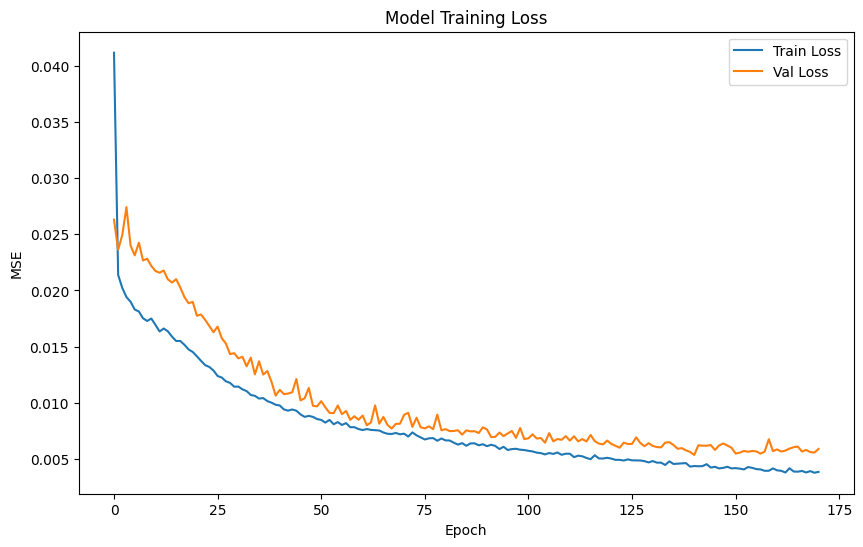

In [38]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [39]:
y_pred_scaled = model.predict(X_test)
y_pred = inverse_price(y_pred_scaled)
y_true = inverse_price(y_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE:  {mae:.2f}")
print(f"Test MAPE: {mape:.2f}%")

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Test RMSE: 3071.77
Test MAE:  1957.15
Test MAPE: 48.54%


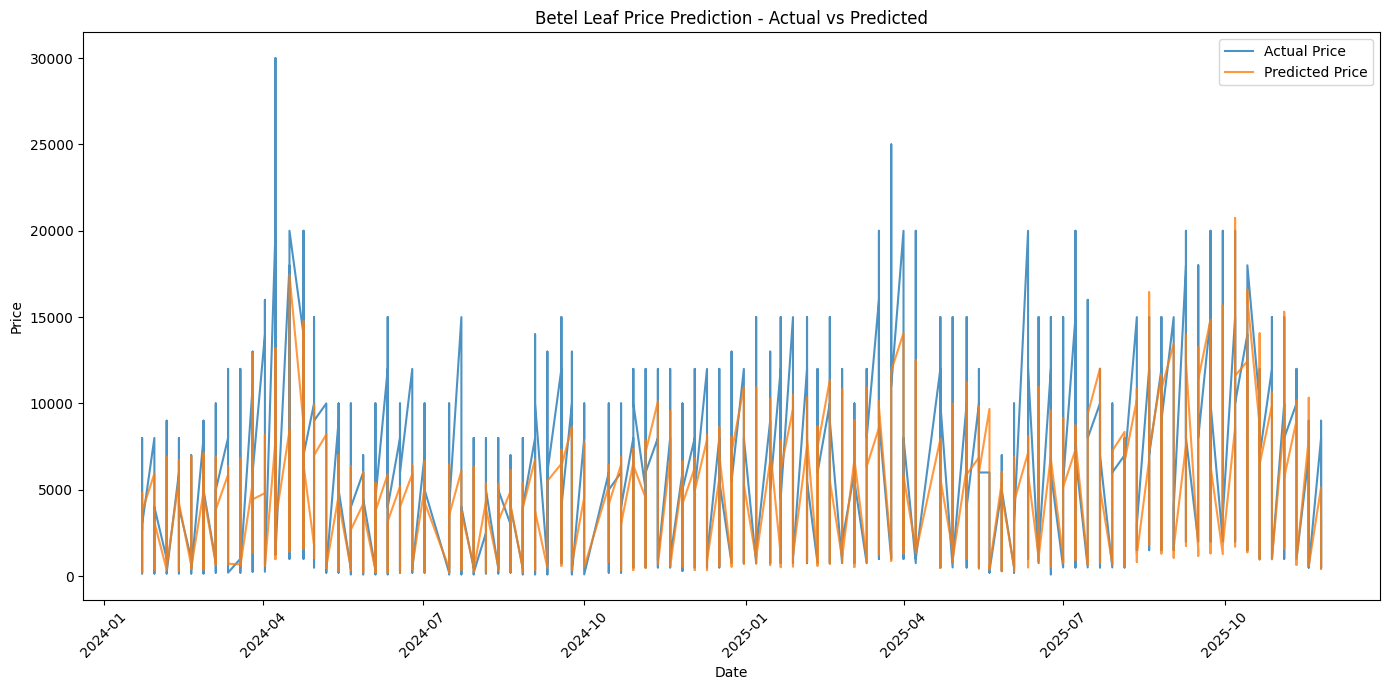

In [40]:
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_true, label='Actual Price', alpha=0.8)
plt.plot(test_dates, y_pred, label='Predicted Price', alpha=0.8)
plt.title('Betel Leaf Price Prediction - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [41]:
model.save('betel_price_lstm_model.h5')
joblib.dump(scaler_price, 'betel_price_log_scaler.pkl')
print("Model and scaler saved successfully!")

Model and scaler saved successfully!
